# **FUNNEL ANALYSIS AND PRODUCT RECOMENDATIONS**

In [1]:
import warnings

warnings.simplefilter(action = 'ignore')

In [2]:
import numpy as np
import pandas as pd

import retentioneering

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

## **1. DATA LOADING AND PREPROCESSING**

In [3]:
df = pd.read_csv('funnel_dataset.csv')

In [4]:
df.head()

,Unnamed: 0,channel,client_id,event,platform,region,timestamp,user_type
0,0,fb,34779607,main,android,moscow,2019-11-13 00:19:22.052321,user__search
1,1,fb,34779607,catalog/motorbikes,android,moscow,2019-11-13 00:19:23.389054,user__search
2,2,fb,34779607,"catalog/motorbikes/Harley-Davidson, CVO™ Limit...",android,moscow,2019-11-13 00:19:38.941330,user__search
3,3,fb,35773238,catalog/motorbikes,iOS,moscow,2020-01-07 16:55:35.349857,user__search
4,4,fb,35773238,"catalog/motorbikes/Road Glide Limited 114, Har...",iOS,moscow,2020-01-07 16:55:42.490744,user__search


In [5]:
print('Number of observations:', len(df))

Number of observations: 69841


**— Checking missing values and unique values.**

In [6]:
df.isnull().sum()

Unnamed: 0    0
channel       0
client_id     0
event         0
platform      0
region        0
timestamp     0
user_type     0
dtype: int64

In [7]:
print('Channels:', df['channel'].unique().tolist(), '\n')
print('Platforms:', df['platform'].unique().tolist(), '\n')
print('Regions:', df['region'].unique().tolist(), '\n')
print('Events:', df['event'].unique().tolist())

Channels: ['fb', 'vk'] 

Platforms: ['android', 'iOS', 'PC'] 

Regions: ['moscow', 'spb', 'kaliningrad'] 

Events: ['main', 'catalog/motorbikes', 'catalog/motorbikes/Harley-Davidson, CVO™ Limited® (Flhtkse), 2020', 'catalog/motorbikes/Road Glide Limited 114, Harley-Davidson (2020)', 'catalog/motorbikes/CVO™ Limited® (FLHTKSE), 2020 Harley-Davidson', 'catalog/tools', 'catalog/tools/49320-09 НАБОР ДУГ ЗАЩИТНЫХ ДВИГАТЕЛЯ, BLACK Harley Davidson', 'catalog/tools/67700455 KIT ФАРЫ МОТОЦИКЛА Harley Davidson', 'request_call', 'catalog/tools/55800646 РУЛЬ ДЛЯ МОТОЦИКЛА СОСТАВНОЙ', 'call_made']


— **Since we are interested in motorbikes, we are filtering data and save it in a new DataFrame.**

In [8]:
motorbike_df = df.copy()

In [9]:
motorbike_df['timestamp'] = pd.to_datetime(motorbike_df['timestamp'])
motorbike_df = motorbike_df.sort_values('timestamp')

In [10]:
def map_motorbikes_events(event): 
    
    mapped_event = np.nan
    
    if event in ('main', 'catalog/motorbikes', 'request_call', 'call_made'):
        mapped_event = event
    
    if str(event).startswith('catalog/motorbikes/'):
        mapped_event = 'catalog/motorbikes/some_motorbike'
    
    return mapped_event

In [11]:
motorbike_df['mapped_event'] = motorbike_df['event'].apply(map_motorbikes_events)

motorbike_df.dropna(subset = ['mapped_event'], inplace = True)
motorbike_df.reset_index(drop = True, inplace = True)

In [12]:
motorbike_df.dropna(subset = ['mapped_event'], inplace = True)

In [13]:
print('Number of observations:', len(motorbike_df))

Number of observations: 59945


## **2. EVENTS ANALYSIS**

**— We are interested in the funnel from the initial stage of product use to the customer interaction stage.**

**Therefore we are using the following main events in user interaction with the product: going to the main page (```main```), going to the catalog page (```catalog/motorbikes```), going to the motorbike page in the catalog (```catalog/motorbikes/some_motorbike```), sending a request for a call (```request_call```) and making a call to a user (```call_made```).**

In [14]:
motorbike_steps = ['main', 
                  'catalog/motorbikes', 
                  'catalog/motorbikes/some_motorbike', 
                  'request_call', 
                  'call_made']

In [15]:
def create_funnel_df(df, steps, closed = True): 
    
    df = df.copy()
    
    df = df[['client_id', 'mapped_event', 'timestamp']]
    df = df[df['mapped_event'].isin(steps)]
    
    values = []
    
    for i, step in enumerate(steps):
        
        if i == 0: 
            
            dfs = {}
            dfs[step] = df[df['mapped_event'] == step].sort_values(['client_id', 'timestamp'], ascending = True).drop_duplicates(subset = ['client_id', 'mapped_event'], keep = 'first')
            
        else: 
            
            dfs[step] = df[df['mapped_event'] == step]

            if not closed: 
                
                dfs[step].drop_duplicates(subset = ['client_id'], inplace = True)
            
            else: 
                
                merged = pd.merge(dfs[steps[i - 1]], dfs[step], on = 'client_id', how = 'outer')
                
                valid_ids = dfs[steps[i - 1]]['client_id'].unique()
                merged = merged[merged['client_id'].isin(valid_ids)]
                
                merged = merged[merged['timestamp_y'] >= (merged['timestamp_x'])].sort_values('timestamp_y', ascending = True)
                merged = merged.drop_duplicates(subset = ['client_id', 'mapped_event_x', 'mapped_event_y'], keep = 'first')
                
                merged = merged[['client_id', 'mapped_event_y', 'timestamp_y']].rename({'mapped_event_y' : 'mapped_event', 'timestamp_y' : 'timestamp'}, axis = 1)

                dfs[step] = merged

        values.append(len(dfs[step]))

    funnel_df = pd.DataFrame({'step' : steps, 'count' : values})
    funnel_df['cr'] = round((100 - 100 * abs(funnel_df['count'].pct_change()).fillna(0)), 2)
    funnel_df['cr_from_first'] = round((funnel_df['count'] / funnel_df['count'].loc[0] * 100).fillna(0), 2)

    return funnel_df

### **2.1. STEP MATRIX**

In [16]:
retentioneering.config.update({'user_col' : 'client_id', 
                               'event_col' : 'mapped_event',
                               'event_time_col' : 'timestamp'})

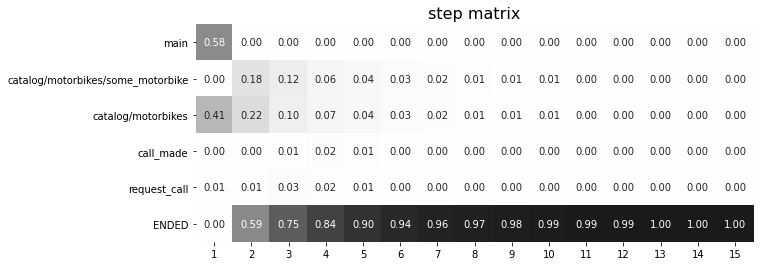

In [17]:
motorbike_step_matrix = motorbike_df.rete.step_matrix(max_steps = 15)

### **2.2. CLOSED FUNNEL**

In [18]:
df_closed_funnel = create_funnel_df(motorbike_df, motorbike_steps)

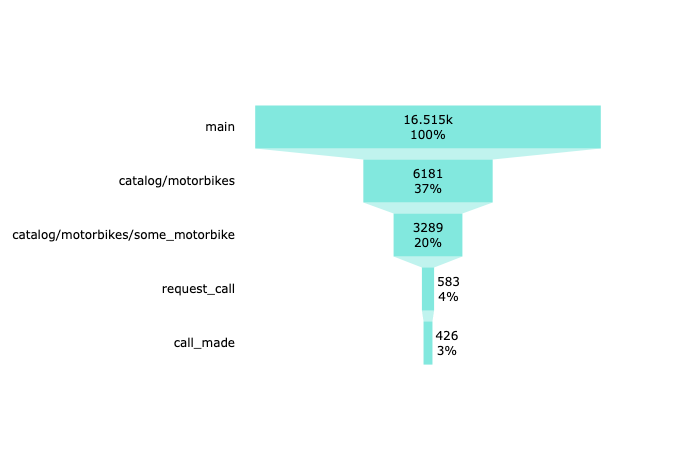

In [19]:
fig = go.Figure(go.Funnel(y = df_closed_funnel['step'], x = df_closed_funnel['count'], 
                          textinfo = 'value+percent initial', 
                          marker = {'color' : '#82e8de'}, textfont = dict(color = '#000000')))

fig.update_layout(font = dict(color = '#000000'), plot_bgcolor = '#ffffff')

fig.show('png')

### **2.3. OPEN FUNNEL**

In [20]:
df_open_funnel = create_funnel_df(motorbike_df, motorbike_steps, closed = False)

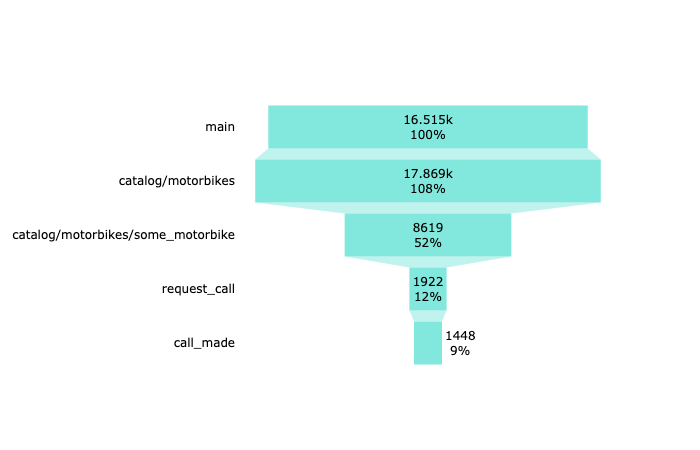

In [21]:
fig = go.Figure(go.Funnel(y = df_open_funnel['step'], 
                          x = df_open_funnel['count'], 
                          textinfo = 'value+percent initial', 
                          marker = {'color' : '#82e8de'}, textfont = dict(color = '#000000')))

fig.update_layout(font = dict(color = '#000000'), plot_bgcolor = '#ffffff')

fig.show('png')

**— User interaction with the product is carried out through the open funnel. The interaction can start on the main page, on the catalog page and, in rare occasions, on the page for sending a request for a call.**

**By visualizing both closed and open funnels, it can be seen that the conversion rate between the motorbike page in the catalog (```catalog/motorbikes/some_motorbike```) and the user sending a request for a call page (```request_call```) is quite small. Perhaps the fact is that the application form does not attract the attention of users. In this case, its design should be reconsidered.**

**Let's analyze the open funnel in terms of ```region```, ```channel``` and ```platform``` variables.**

In [22]:
df_open_funnel_spb = create_funnel_df(motorbike_df[motorbike_df['region'] == 'spb'], motorbike_steps, closed = False)
df_open_funnel_moscow = create_funnel_df(motorbike_df[motorbike_df['region'] == 'moscow'], motorbike_steps, closed = False)
df_open_funnel_kaliningrad = create_funnel_df(motorbike_df[motorbike_df['region'] == 'kaliningrad'], motorbike_steps, closed = False)

df_open_funnel_spb['region'] = 'spb'
df_open_funnel_moscow['region'] = 'moscow'
df_open_funnel_kaliningrad['region'] = 'kaliningrad'

df_open_funnel_region = pd.concat([df_open_funnel_spb, df_open_funnel_moscow, df_open_funnel_kaliningrad], axis = 0).reset_index(drop = True)

first_column = df_open_funnel_region.pop('region')
df_open_funnel_region.insert(0, 'region', first_column)

In [23]:
df_open_funnel_region

,region,step,count,cr,cr_from_first
0,spb,main,3242,100.00,100.00
1,spb,catalog/motorbikes,3568,89.94,110.06
2,spb,catalog/motorbikes/some_motorbike,1755,49.19,54.13
3,spb,request_call,379,21.60,11.69
4,spb,call_made,338,89.18,10.43
5,moscow,main,10045,100.00,100.00
6,moscow,catalog/motorbikes,10751,92.97,107.03
7,moscow,catalog/motorbikes/some_motorbike,5160,48.00,51.37
8,moscow,request_call,1138,22.05,11.33
9,moscow,call_made,1033,90.77,10.28


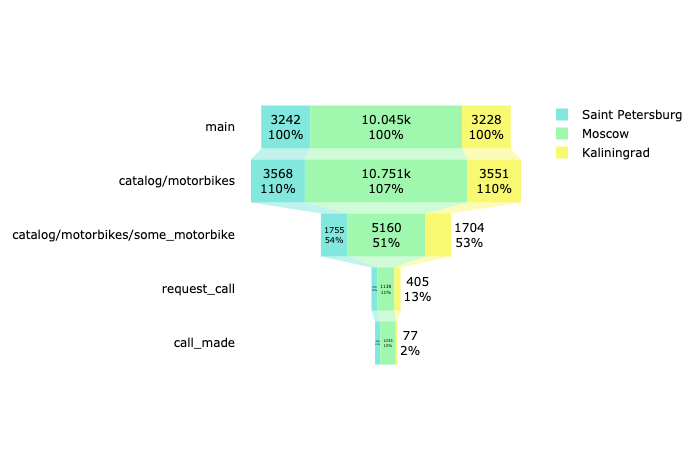

In [24]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'Saint Petersburg', 
                        y = df_open_funnel_region[df_open_funnel_region['region'] == 'spb']['step'], 
                        x = df_open_funnel_region[df_open_funnel_region['region'] == 'spb']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#82e8de'}, textfont = dict(color = '#000000')))

fig.add_trace(go.Funnel(name = 'Moscow', 
                        y = df_open_funnel_region[df_open_funnel_region['region'] == 'moscow']['step'], 
                        x = df_open_funnel_region[df_open_funnel_region['region'] == 'moscow']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#a0f8af'}, textfont = dict(color = '#000000')))

fig.add_trace(go.Funnel(name = 'Kaliningrad', 
                        y = df_open_funnel_region[df_open_funnel_region['region'] == 'kaliningrad']['step'], 
                        x = df_open_funnel_region[df_open_funnel_region['region'] == 'kaliningrad']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#f9f871'}, textfont = dict(color = '#000000')))

fig.update_layout(font = dict(color = '#000000'), plot_bgcolor = '#ffffff')

fig.show('png')

**— The conversion rate between sending a request for a call (```request_call```) and making a call to a user (```call_made```) in Kaliningrad is small and significantly different from the conversion rate in Saint Petersburg and Moscow - 19% versus 89% and 91% respectively. To solve this problem, it is necessary to analyze the work of specialists from Kaliningrad whose duties include user calls processing.**

In [25]:
df_open_funnel_fb = create_funnel_df(motorbike_df[motorbike_df['channel'] == 'fb'], motorbike_steps, closed = False)
df_open_funnel_vk = create_funnel_df(motorbike_df[motorbike_df['channel'] == 'vk'], motorbike_steps, closed = False)

df_open_funnel_fb['channel'] = 'fb'
df_open_funnel_vk['channel'] = 'vk'

df_open_funnel_channel = pd.concat([df_open_funnel_fb, df_open_funnel_vk], axis = 0).reset_index(drop = True)

first_column = df_open_funnel_channel.pop('channel')
df_open_funnel_channel.insert(0, 'channel', first_column)

In [26]:
df_open_funnel_channel

,channel,step,count,cr,cr_from_first
0,fb,main,10038,100.00,100.00
1,fb,catalog/motorbikes,11959,80.86,119.14
2,fb,catalog/motorbikes/some_motorbike,7767,64.95,77.38
3,fb,request_call,1720,22.14,17.13
4,fb,call_made,1294,75.23,12.89
5,vk,main,6477,100.00,100.00
6,vk,catalog/motorbikes,5910,91.25,91.25
7,vk,catalog/motorbikes/some_motorbike,852,14.42,13.15
8,vk,request_call,202,23.71,3.12
9,vk,call_made,154,76.24,2.38


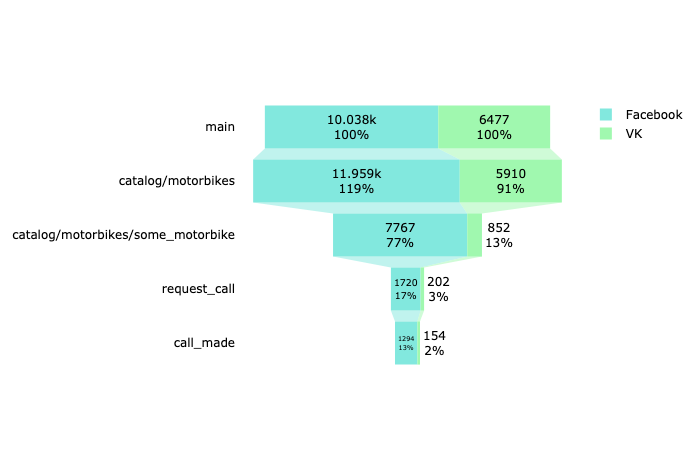

In [27]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'Facebook', 
                        y = df_open_funnel_channel[df_open_funnel_channel['channel'] == 'fb']['step'], 
                        x = df_open_funnel_channel[df_open_funnel_channel['channel'] == 'fb']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#82e8de'}, textfont = dict(color = '#000000')))

fig.add_trace(go.Funnel(name = 'VK', 
                        y = df_open_funnel_channel[df_open_funnel_channel['channel'] == 'vk']['step'], 
                        x = df_open_funnel_channel[df_open_funnel_channel['channel'] == 'vk']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#a0f8af'}, textfont = dict(color = '#000000')))

fig.update_layout(font = dict(color = '#000000'), plot_bgcolor = '#ffffff')

fig.show('png')

**— In terms of advertising channels, problems in the conversion rate are observed for the VK channel between the catalog page (```catalog/motorbikes```) and the motorbike page in the catalog (```catalog/motorbikes/some_motorbike```). It is necessary to test the functionality of the product when opening it through the VK channel.**

In [28]:
df_open_funnel_pc = create_funnel_df(motorbike_df[motorbike_df['platform'] == 'PC'], motorbike_steps, closed = False)
df_open_funnel_android = create_funnel_df(motorbike_df[motorbike_df['platform'] == 'android'], motorbike_steps, closed = False)
df_open_funnel_ios = create_funnel_df(motorbike_df[motorbike_df['platform'] == 'iOS'], motorbike_steps, closed = False)

df_open_funnel_pc['platform'] = 'PC'
df_open_funnel_android['platform'] = 'android'
df_open_funnel_ios['platform'] = 'iOS'

df_open_funnel_platform = pd.concat([df_open_funnel_pc, df_open_funnel_android, df_open_funnel_ios], axis = 0).reset_index(drop = True)

first_column = df_open_funnel_platform.pop('platform')
df_open_funnel_platform.insert(0, 'platform', first_column)

In [29]:
df_open_funnel_platform

,platform,step,count,cr,cr_from_first
0,PC,main,4958,100.00,100.00
1,PC,catalog/motorbikes,4903,98.89,98.89
2,PC,catalog/motorbikes/some_motorbike,2295,46.81,46.29
3,PC,request_call,1213,52.85,24.47
4,PC,call_made,910,75.02,18.35
5,android,main,6605,100.00,100.00
6,android,catalog/motorbikes,7487,86.65,113.35
7,android,catalog/motorbikes/some_motorbike,3655,48.82,55.34
8,android,request_call,407,11.14,6.16
9,android,call_made,319,78.38,4.83


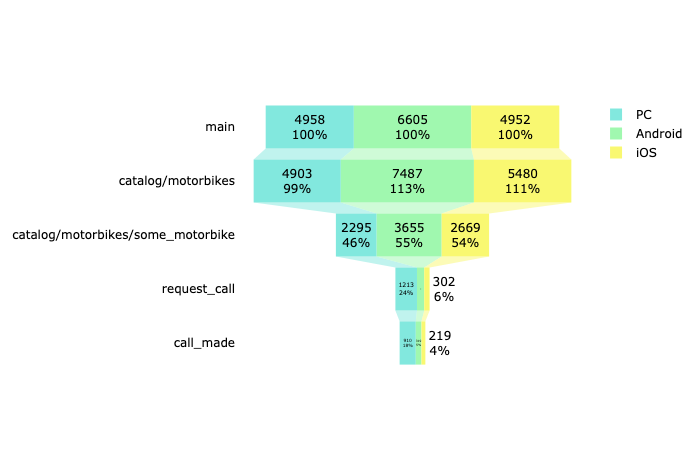

In [30]:
fig = go.Figure()

fig.add_trace(go.Funnel(name = 'PC', 
                        y = df_open_funnel_platform[df_open_funnel_platform['platform'] == 'PC']['step'], 
                        x = df_open_funnel_platform[df_open_funnel_platform['platform'] == 'PC']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#82e8de'}, textfont = dict(color = '#000000')))

fig.add_trace(go.Funnel(name = 'Android', 
                        y = df_open_funnel_platform[df_open_funnel_platform['platform'] == 'android']['step'], 
                        x = df_open_funnel_platform[df_open_funnel_platform['platform'] == 'android']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#a0f8af'}, textfont = dict(color = '#000000')))

fig.add_trace(go.Funnel(name = 'iOS', 
                        y = df_open_funnel_platform[df_open_funnel_platform['platform'] == 'iOS']['step'], 
                        x = df_open_funnel_platform[df_open_funnel_platform['platform'] == 'iOS']['count'], 
                        textinfo = 'value+percent initial', 
                        marker = {'color' : '#f9f871'}, textfont = dict(color = '#000000')))

fig.update_layout(font = dict(color = '#000000'), plot_bgcolor = '#ffffff')

fig.show('png')

**— Similar to the case with advertising channels, problems with the conversion rate between the catalog page (```catalog/motorbikes```) and the motorbike page in the catalog (```catalog/motorbikes/some_motorbike```) occur in the mobile version of the product.**